CNNの勉強

MNISTデータセットを使う5層のCNNモデルを作成する

CPUで2.5時間、GPUを使えばそれより早い学習時間になる

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

/home/serizawa/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load the data
train = pd.read_csv("../data/cnn_train.csv")
test = pd.read_csv("../data/cnn_test.csv")

# Preprocessing

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

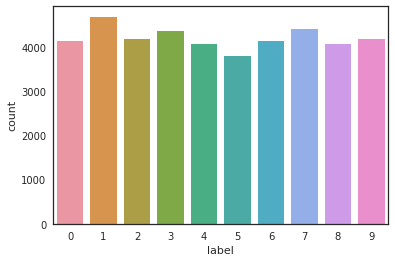

In [3]:
#学習データをラベルと分割
X_train = train.drop(columns='label')
y_train = train['label']

del train

#データ数確認
g = sns.countplot(y_train)
y_train.value_counts()

In [4]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [5]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
#正規化

#明るさの違いを減らすため、グレースケール化する(今回のMNISTは元からグレースケール画像)
#また、CNNは[0...255]より[0...1]の方が早く収束する

X_train = X_train/255.0
test = test/255.0

In [7]:
#Reshape

#trainもtestも28*28の784値を持つ1Dベクトル画像
#これを28*28の3Dマトリックスに再構成する

#MNIST画像はグレースケールであるため、1つのチャンネルのみを使用する
#RGB画像の場合、3つのチャンネルがあり、784pxベクトルを28x28x3の3Dマトリックスに再構成する
#(-1:任意を示す, 28,28:画像サイズ, 1:チャンネル数(グレースケール))

X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [8]:
#Label Encoding

#0~9まであるラベルを1つのホットベクトルに変換する
#例：2 -> [0,0,1,0,0,0,0,0,0,0]
y_train = to_categorical(y_train, num_classes=10)

In [9]:
#trainとtest分割
X_train, x_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=2)

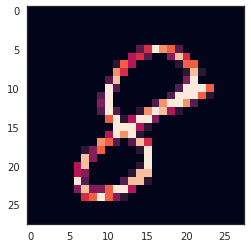

In [10]:
#Image visualization
g = plt.imshow(X_train[0][:,:,0])

# CNN Modeling

## Architecture

In -> 2*(2*(Conv2D -> ReLU) -> MaxPool2D -> Droput) -> Flatten -> Dence -> Dropout -> Out

padding: Same or Valid (zero_padding is Same)

Flatten: 1次元にデータ変形

Dense: 全結合層

Dropout: ネットワークをランダムに切ることで削減

In [11]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same',
                 activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same',
                 activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

## Parameters
スコア関数、損失関数、最適化アルゴリズムを設定

最適化アルゴリズム:
SGD(確率的勾配降下法)

MomentumSGD(確率的勾配降下法の収束速度を上げた改良版)

AdaGrad

AdaDelta

Adam

NesterovAG

RMSprop(MNISTでは最も優れた最適化手法の一つ)

In [12]:
# Define the optimizer(最適化)
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [13]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy",
              metrics=["accuracy"])

In [14]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [15]:
#epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
#batch_size = 86

In [16]:
# オーバーフィッチング問題を対処しない状態での実行
#history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, 
#          validation_data = (x_test, y_test), verbose = 2, callbacks=[learning_rate_reduction])

## Data augmentation
データを回転させたりノイズを入れることで過学習を防ぎつつ学習データを増加させる

In [17]:
#vertical_flipやholizontal_flipは6と9のようなものを誤学習する恐れがあるので使わない
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [18]:
epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [19]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
print("\nfinish!")

Epoch 1/30
 - 7s - loss: 0.4133 - acc: 0.8696 - val_loss: 0.0977 - val_acc: 0.9736
Epoch 2/30
 - 6s - loss: 0.1302 - acc: 0.9609 - val_loss: 0.0477 - val_acc: 0.9881
Epoch 3/30
 - 6s - loss: 0.0952 - acc: 0.9717 - val_loss: 0.0420 - val_acc: 0.9871
Epoch 4/30
 - 6s - loss: 0.0798 - acc: 0.9764 - val_loss: 0.0371 - val_acc: 0.9900
Epoch 5/30
 - 6s - loss: 0.0741 - acc: 0.9785 - val_loss: 0.0285 - val_acc: 0.9917
Epoch 6/30
 - 6s - loss: 0.0665 - acc: 0.9807 - val_loss: 0.0241 - val_acc: 0.9919
Epoch 7/30
 - 6s - loss: 0.0638 - acc: 0.9809 - val_loss: 0.0311 - val_acc: 0.9900
Epoch 8/30
 - 6s - loss: 0.0627 - acc: 0.9825 - val_loss: 0.0202 - val_acc: 0.9943
Epoch 9/30
 - 6s - loss: 0.0630 - acc: 0.9820 - val_loss: 0.0245 - val_acc: 0.9924
Epoch 10/30
 - 6s - loss: 0.0609 - acc: 0.9835 - val_loss: 0.0257 - val_acc: 0.9907
Epoch 11/30
 - 6s - loss: 0.0614 - acc: 0.9833 - val_loss: 0.0231 - val_acc: 0.9940

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoc

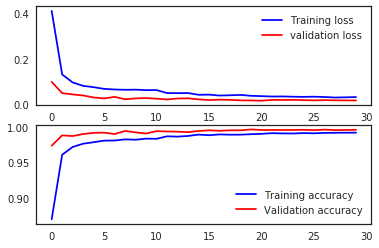

In [20]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Confusion matrix
検証結果から問題を探す
TrueとPredが一致しているかを見ることができる

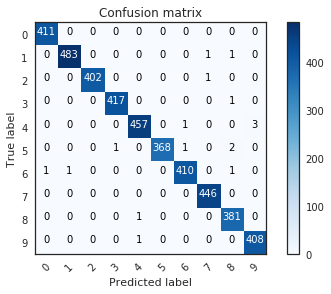

In [21]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

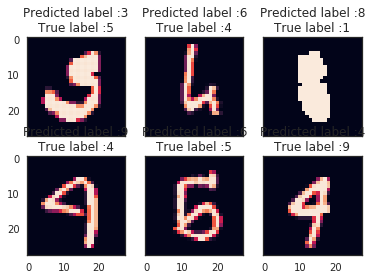

In [22]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (y_pred_classes - y_true != 0)

y_pred_classes_errors = y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
x_val_errors = x_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
y_pred_errors_prob = np.max(y_pred_errors, axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, x_val_errors, y_pred_classes_errors, y_true_errors)

## Final Pred.

In [23]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results, axis = 1)

results = pd.Series(results, name="Label")

In [24]:
submission = pd.concat([pd.Series(range(1, 28001), name = "ImageId"), results], axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)